In [53]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import matplotlib.pyplot as plt
import math
import SALib
from scipy.optimize import fsolve
from scipy.constants import N_A

In [54]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*100000000
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [55]:
(1e6*(tumour_cell_surface_area**2)*3/(N_A*4*1e-15*2*math.pi))**(1/3)

5.042393367698325e-08

In [56]:
rtot = 1e2
(np.sqrt((4*math.pi*((tumour_cell_radius)**2))/rtot))

2.8359261614488256e-06

In [57]:
def model_R_monospecific(t, z, Ainit, kon, koff, r_ab, rtot):
    k = Ainit*kon
    Atot = well_size*N_A*Ainit/Target_cell_number
    reaction_volume = (2*math.pi*(r_ab**3))/3
    A0 = Atot - z[0] - z[1] 
    Ag = rtot - z[0] - 2*z[1]
    target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
    k2 = target_effective_conc1*kon
    dA10 = 2*(k*Ag*A0/(Atot)) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
    dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

    return [dA10, dA11]

In [58]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'r_ab', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [2e-11, 2e-7],
               [1e-6, 1e-1],
               [1, 1000]]
}

In [59]:
vals = SALib.sample.sobol.sample(problem1, 262144)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [60]:
16384*16

262144

In [61]:
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
      
        rtot = params[0]
        kon = params[1]
        r_ab = params[2]
        koff = params[3]
        dummy = params[4]

        reaction_volume = (2/3)*math.pi*((r_ab)**3)
        target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
        k2 = target_effective_conc*kon/rtot

        if Ainit < 1e-8:
            guess = 0
        else:
            guess = 10

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag = (A1_st + 2*A2_st)/rtot
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.860210  0.139733
kon    0.100955  0.027643
r_ab   0.674210  0.148661
koff   0.357369  0.107895
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.104054  0.066611
kon    0.008869  0.001779
r_ab   0.034598  0.007677
koff   0.018081  0.004301
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)   -0.004043  0.071259
(rtot, r_ab)   0.456428  0.233305
(rtot, koff)   0.086801  0.091495
(rtot, dummy) -0.024042  0.072815
(kon, r_ab)   -0.000181  0.001802
(kon, koff)   -0.000140  0.001954
(kon, dummy)  -0.000213  0.001432
(r_ab, koff)   0.006407  0.014551
(r_ab, dummy)  0.006774  0.015640
(koff, dummy)  0.004788  0.014167
1e-10


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.842447  0.036300
kon    0.124631  0.008636
r_ab   0.605001  0.033024
koff   0.287118  0.020284
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.147364  0.015109
kon    0.024701  0.001883
r_ab   0.088171  0.006842
koff   0.043856  0.005781
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.024870  0.025284
(rtot, r_ab)   0.394840  0.057855
(rtot, koff)   0.141733  0.031809
(rtot, dummy) -0.000716  0.022628
(kon, r_ab)    0.001142  0.002973
(kon, koff)    0.000513  0.003213
(kon, dummy)  -0.000259  0.002431
(r_ab, koff)   0.002763  0.011682
(r_ab, dummy)  0.000459  0.012033
(koff, dummy)  0.000527  0.009539
1e-09


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.584149  0.007297
kon    0.165298  0.002946
r_ab   0.497690  0.007522
koff   0.265332  0.004774
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.170903  0.006157
kon    0.081221  0.002159
r_ab   0.206213  0.005003
koff   0.106607  0.003327
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.029149  0.009502
(rtot, r_ab)   0.219843  0.012537
(rtot, koff)   0.102697  0.010163
(rtot, dummy) -0.000578  0.008672
(kon, r_ab)    0.006365  0.003365
(kon, koff)    0.002523  0.003359
(kon, dummy)  -0.000043  0.003070
(r_ab, koff)   0.009047  0.007477
(r_ab, dummy) -0.000287  0.007139
(koff, dummy) -0.000024  0.004442
1e-08


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


negative
blown up
negative
blown up
negative
blown up


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
b

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up
negative
blown up


KeyboardInterrupt: 

In [ ]:
16384*2*2

65536

In [ ]:
(3*1e4*1e3*tumour_cell_surface_area/(2*1e4*N_A*math.pi))**(1/3)

8.607164580321545e-11

Text(0, 0.5, 'Total Order Sobol Indicies')

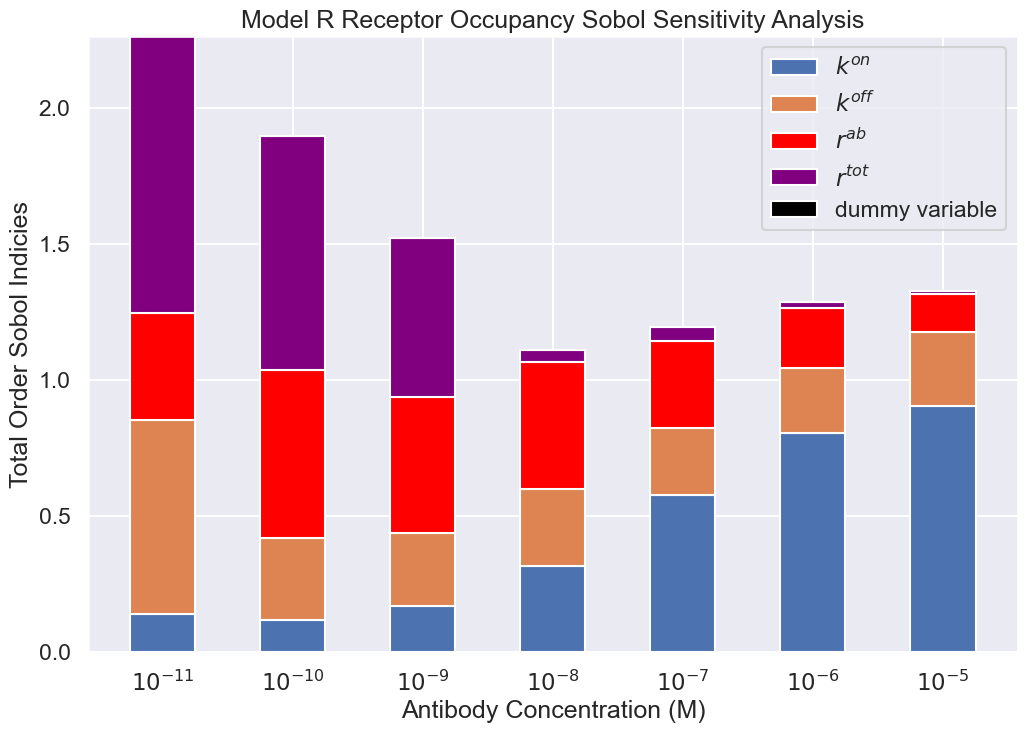

In [ ]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
r_ab_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies)):
    vals = indicies[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    r_ab_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
}

sns.set_theme()
sns.set_context("talk")
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.bar(ab_conc, r_ab_si, width, label=r'$r^{ab}$', bottom= bottom, color='red')
bottom+= r_ab_si
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model R Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')

Text(0, 0.5, 'First Order Sobol Indicies')

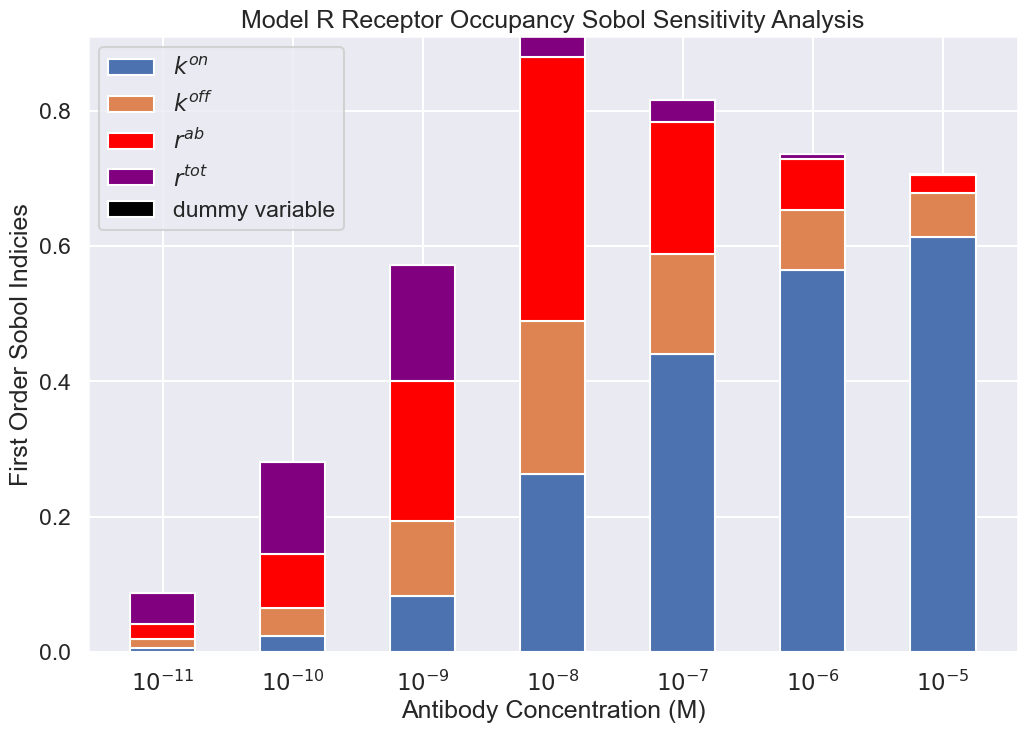

In [ ]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
r_ab_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies_1)):
    vals = indicies_1[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    r_ab_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
}

sns.set_theme()
sns.set_context("talk")
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.bar(ab_conc, r_ab_si, width, label=r'$r^{ab}$', bottom= bottom, color='red')
bottom+= r_ab_si
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model R Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('First Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')